# A Hands-On Walkthrough on Model Quantization

# Introduction

# What is Quantization?
Quantization is a technique used to reduce the computational and memory overhead of a machine learning model by reducing the precision of the numbers used to represent the model's parameters. Typically, models use **32-bit floating-point numbers**, but quantization converts these to **8-bit integers** (or 4-bit integers). This can significantly reduce the model size and increase the inference speed, especially on CPUs and other hardware with limited computational resources. While this can lead to a slight reduction in model accuracy, the trade-off is often worthwhile for faster and more efficient deployments.

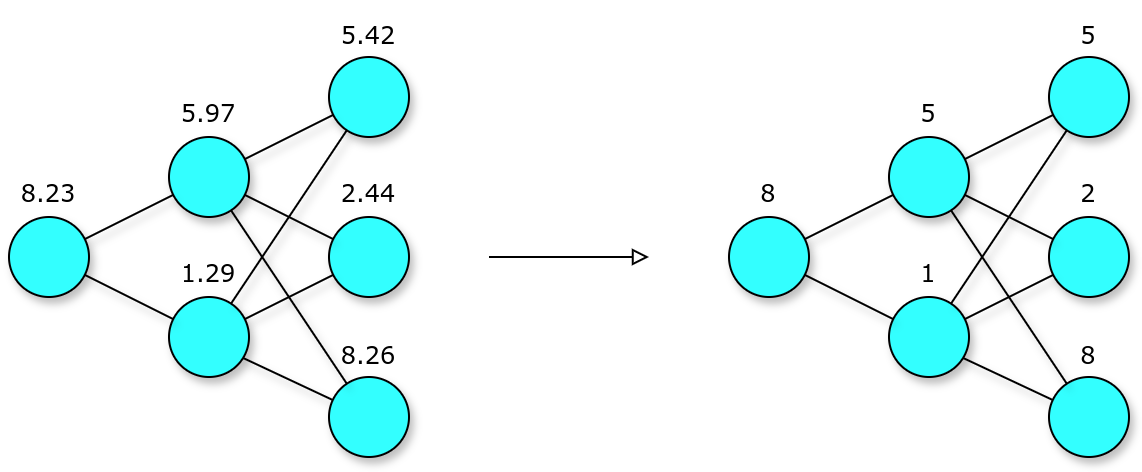

# Why to quantize a machine learning model?
* **Reduced Model Size**: Quantization can reduce the model size by up to 1/4 of the original. This is very important for deployment in storage-limited environments.
* **Increased Inference Speed**: Quantized models can significantly improve inference speed by reducing the precision of weights and activations, thereby decreasing the computational workload during inference. These improvements are more noticeable on CPUs.

# About this notebook
This notebook demonstrates the process of quantizing and saving a Transformer model to improve the inference speed on a CPU and reduce the model size. The notebook is structured into the following sections:

1. Installations
2. Imports
3. Set Device
4. Inference
5. Save Quantized Model
6. Load Saved Quantized Model for Inference

**Note**: This notebook is designed to run on a CPU to demonstrate the improvements in inference speed after quantization.

# Useful Links

*  [Model compression and optimization: Why think bigger when you can think smaller?](https://medium.com/data-science-at-microsoft/model-compression-and-optimization-why-think-bigger-when-you-can-think-smaller-216ec096f68b)
*  [HuggingFace Guide for Quantization](https://huggingface.co/docs/optimum/en/concept_guides/quantization)
*  [HuggingFace Discussion for Quantization](https://discuss.huggingface.co/t/fast-cpu-inference-on-pegasus-large-finetuned-model-currently-impossible/4048/2)
*  [PyTorch documentation for quantization with quantize_dynamic](https://pytorch.org/docs/stable/generated/torch.ao.quantization.quantize_dynamic.html)


# Installations

In [ ]:
!pip install transformers==4.42.3
!pip install sentencepiece==0.2.0

# Imports

In [ ]:
import torch, time
from torch.quantization import quantize_dynamic
from transformers import AutoConfig, AutoTokenizer, AutoModelForSeq2SeqLM

# Set Device

This notebook is designed to run on a CPU. Shifting from fp32 to int8 offers significant benefits for model inference on CPUs. However, for running quantized models on GPUs, int8 quantization is generally less common. In most cases, using fp16 instead of fp32 provides sufficient speed improvements for model inference on GPUs.






In [ ]:
device = "cpu"

# Inference

## Set model name
For this notebook, we use the [financial-summarization-pegasus](https://huggingface.co/human-centered-summarization/financial-summarization-pegasus) model. This model was fine-tuned on a novel financial news dataset, which consists of 2K articles from Bloomberg, on topics such as stock, markets, currencies, rate and cryptocurrencies. It is based on the PEGASUS model and in particular PEGASUS fine-tuned on XSum dataset.

Feel free to adjust the code below to use any model from the HuggingFace hub or load your own model from a local path.


In [ ]:
model_name = 'human-centered-summarization/financial-summarization-pegasus'



## Load Model and Tokenizer

In this section, we will load the pre-trained model and tokenizer. These components are essential for preparing the input data and generating predictions. The tokenizer will convert our text into a format the model can understand and the model will process this input to produce the desired output.

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

## Quantize Model

Here, we convert the model into a quantized form using 8-bit integers using the `quantize_dynamic` function.








In [ ]:
model_quantized = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

## Set Text to summarize

Here, we set an example financial article for the model to summarize, but you can provide any content you want to summarize.








In [ ]:
text = '''Abu Dhabi National Oil Co. is close to hiring JPMorgan Chase & Co. and First Abu Dhabi Bank PJSC to help arrange the potential listing of its drilling business, according to people familiar with the matter.Adnoc, as the company is known, is looking to sell a minority stake in its drilling unit in a deal that could value the business at up to $10 billion, the people said, declining to be named because the matter is private. In 2018, when Baker Hughes bought a 5% stake in Adnoc Drilling, that deal valued the company at about $11 billion, including $1 billion of debt.Although the state energy firm has yet to award formal mandates, the two banks are in pole position for a role on the IPO at the Abu Dhabi Securities Exchange, the people said. Adnoc may also appoint additional advisers, they said.Adnoc and JPMorgan declined to comment. FAB didn’t immediately respond to emails seeking comment.Alongside tapping new revenue sources, Abu Dhabi is looking to revive its dormant stock market by bringing in local or international investors. Government entities such as Adnoc, Mubadala Investment Co. and ADQ have also been exploring different ways to raise cash for their owner.Adnoc recently picked banks for the initial public offering of a fertilizer joint venture called Fertiglobe, while wealth fund Mubadala hired advisers for the listing of satellite operator Yahsat.Abu Dhabi is the capital of the United Arab Emirates and holds most of the country’s crude deposits. The UAE is the third biggest producer in the Organization of Petroleum Exporting Countries, behind Saudi Arabia and Iraq.Unlocking ResourcesAdnoc’s drilling division is responsible for unlocking the UAE’s oil and gas resources on land and at sea, according to its website. It has a fleet of 95 rigs in the Middle East and a workforce of about 7,000 engineers.In recent years, international and local funds have invested more than $20 billion in Adnoc assets such as pipelines and property. Last June, the company sold leasing rights over natural-gas pipelines to a consortium including Global Infrastructure Partners and Brookfield Asset Management Inc., in a deal worth $10.1 billion.Still, its sole IPO to date was the listing of its fuel-retailing unit, Abu Dhabi National Oil Co. for Distribution PJSC, in 2017.(Updates with Adnoc Drilling valuation in 2018 in second paragraph.)'''

We first run the original model without quantization.



In [ ]:
start_non_quantized = time.time()

model_input = tokenizer(text, truncation=True, return_tensors='pt').to(device)
model_output = model.generate(**model_input, max_new_tokens=64)
summary = tokenizer.decode(model_output[0], skip_special_tokens=True)

end_non_quantized = time.time()

print(f"Summary: {summary}")
print(f"Inference time using original model: {end_non_quantized - start_non_quantized}")

Now, we run the quantized version of the model, which converts the model's weights from 32-bit floating point (fp32) to 8-bit integers (int8). This typically results in faster inference times on CPUs due to reduced computation and memory requirements.

You should observe a notable decrease in inference time compared to the original model.

In [ ]:
start_quantized = time.time()

model_input = tokenizer(text, truncation=True, return_tensors='pt').to(device)
model_output = model_quantized.generate(**model_input, max_new_tokens=64)
summary = tokenizer.decode(model_output[0], skip_special_tokens=True)

end_quantized = time.time()

print(f"Summary: {summary}")
print(f"Inference time using quantized model: {end_quantized - start_quantized}")

# Save Quantized Model

In addition to running the quantized model, we can also save it for future use. Replace the path below with the specific path where you want to save the quantized model and model config.


In [ ]:
save_model_path = "/content/quantized_model/"

In [ ]:
model_quantized.config.save_pretrained(save_model_path)

quantized_state_dict = model_quantized.state_dict()
torch.save(quantized_state_dict, save_model_path + "model-quantized.pt")

# Load Saved Quantized Model for Inference



To load the previously saved quantized model, ensure that save_model_path points to the directory where you saved the quantized model and the configuration file you saved alongside the model. Since the tokenizer configuration remains the same, you can load it directly from the Hugging Face hub. If you choose to load the tokenizer from a local path, ensure you have all the necessary files as follows:

*   tokenizer_config.json
*   tokenizer.json
*   spiece.model (if it requires sentencepiece tokenization)
*   special_tokens_map.json





In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

model_config = AutoConfig.from_pretrained(save_model_path)
dummy_model = AutoModelForSeq2SeqLM.from_config(model_config)

quantized_model = torch.quantization.quantize_dynamic(dummy_model, {torch.nn.Linear}, dtype=torch.qint8).to(device)
quantized_model.load_state_dict(torch.load(save_model_path + "model-quantized.pt"))

## Inference with Loaded Quantized Model

In this section, we perform inference again but using the loaded quantized model.



In [ ]:
start = time.time()

model_input = tokenizer(text, return_tensors='pt').to(device)
model_output = quantized_model.generate(**model_input, max_new_tokens=64)
summary = tokenizer.decode(model_output[0], skip_special_tokens=True)

end = time.time()

print(f"Summary: {summary}")
print(f"Inference Time: {end - start}")